In [1]:
%matplotlib inline

import cv2
import glob
import matplotlib.pyplot as plt
import numpy as np
import os.path
import pickle

from moviepy.editor import VideoFileClip
from IPython.display import HTML


In [2]:
# from Udacity example given in lessons
# from https://github.com/udacity/CarND-Camera-Calibration/blob/master/camera_calibration.ipynb

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/cal*.jpg')

for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    img_size = gray.shape[::-1]
    
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)


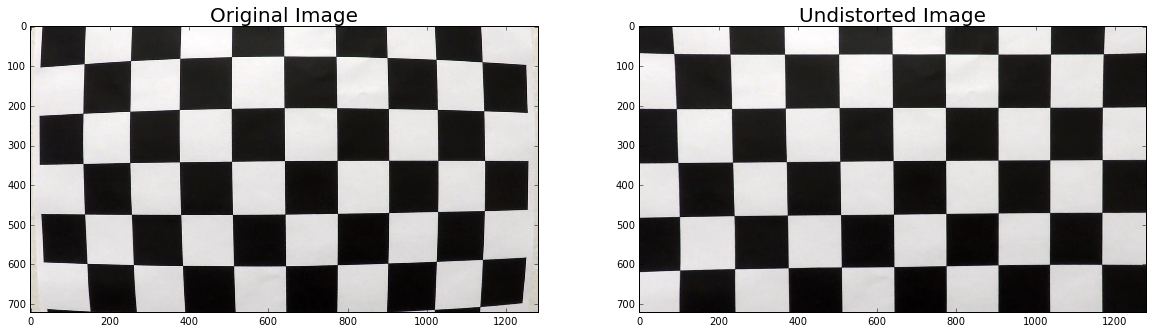

In [3]:
# Test the calibration on one of the example chessboards. 
# It's very obvious that the calibration has fixed the distortion. 
# again pretty much right from Udacity example given in lessons

# Test undistortion on a chessboard image
img = cv2.imread('camera_cal/calibration1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # fix colorspace
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

# undistort the image
dst = cv2.undistort(img, mtx, dist, None, mtx)

# save undistorted image
cv2.imwrite('output_images/calibration_undist.jpg', dst)

# Save the camera calibration results 
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "camera_cal/wide_dist_pickle.p", "wb" ) )

# Visualize 
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=20)


## Test on a real image
### Notice that the left bridge barrier seems to be 'steeper' in the undistroted image. Also, the hood of the car at the bottom of the image is different.

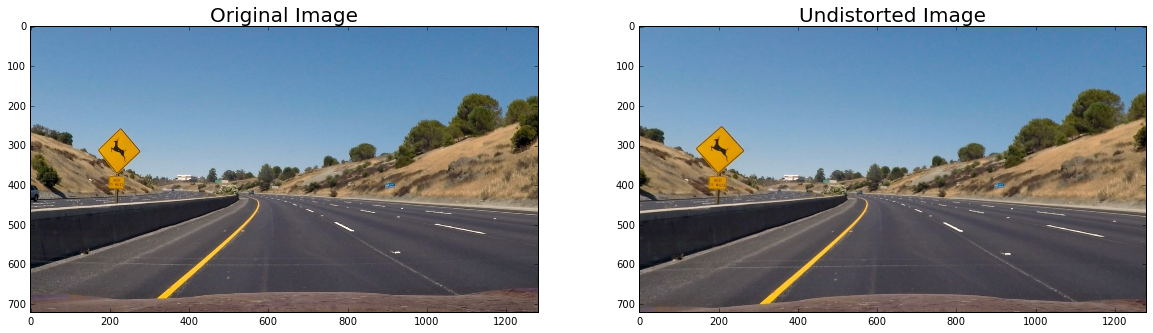

In [4]:
# Test undistortion on a test image
img = cv2.imread('test_images/test2.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # fix colorspace
img_size = (img.shape[1], img.shape[0])

# simple but re-usable later
def undistort(img):
    # undistort using previously found calibration settings
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

undistorted = undistort(img)

# save undistorted image
cv2.imwrite('output_images/test1_undistorted.jpg', cv2.cvtColor(undistorted, cv2.COLOR_RGB2BGR))

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=20)


### Perspective warping/transforming


In [5]:
def perspective_shift(image):
    height,width = img.shape[:2]
    # define source and destination points for transform

    # from the lessons
#     img_size = (image.shape[1], image.shape[0])
#     bot_width = .76      # percentage of bottom trapezoid height
#     mid_width = .08      # percentage of middle trapezoid height
#     height_pct = .62     # percentage for trapezoid height
#     bottom_trim = .935   # percentage top to bottom to avoid car hood
#     src_corners = np.float32([
#         [img.shape[1]*(.5+mid_width/2),img.shape[0]*height_pct],     # top right
#         [img.shape[1]*(.5+bot_width/2),img.shape[0]*bottom_trim],    # bottom right
#         [img.shape[1]*(.5-bot_width/2),img.shape[0]*bottom_trim],    # bottom left
#         [img.shape[1]*(.5-mid_width/2),img.shape[0]*height_pct]      # top left
#     ])
#     offset = img_size[0]*.25
#     dest_corners = np.float32([
#         [img_size[0]-offset,   0],
#         [img_size[0]-offset,   img_size[1]],
#         [offset,               img_size[1]],
#         [offset,               0]
#     ])    

    # This should be done prgramatically in the real world.
    # but tried the above as found in class and it made things worse
    # so for now, shelving it
    src_corners = np.float32([[225,720],[590,450],[690,450],[1025,720]])
    dest_corners = np.float32([[275,720],[275,0],[1025,0],[1025,725]])    
    
    # get the transform matrix and it's inverse 
    # we will need the inverse later for drawing the lane lines
    M = cv2.getPerspectiveTransform(src_corners, dest_corners)
    Minv = cv2.getPerspectiveTransform(dest_corners, src_corners)
    
    # cv2 warps the image so we have a top down view
    image_warped = cv2.warpPerspective(image, M, (width, height), flags=cv2.INTER_LINEAR)

    return image_warped, M, Minv

In [6]:
# test on an image
#image = cv2.imread('test_images/straight_lines2.jpg')
image = cv2.imread('test_images/test2.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # fix colorspace

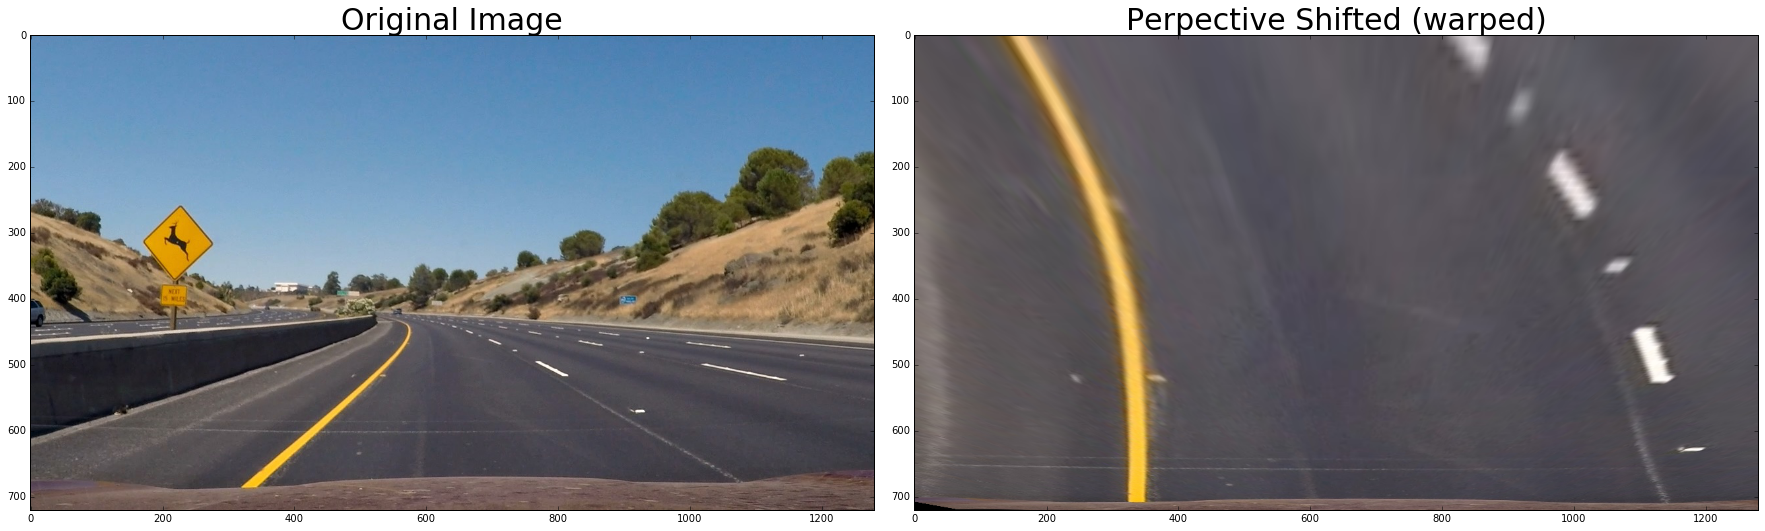

In [7]:
# Show perspective shifted image
# unwarped_image, M, Minv = perspective_shift(image, src_corners, dest_corners)
unwarped_image, M, Minv = perspective_shift(image)

# Plot the result
plt.gcf().clear()
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(unwarped_image)
ax2.set_title('Perpective Shifted (warped)', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)



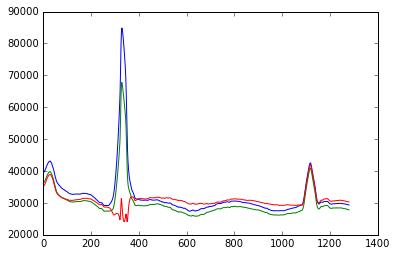

In [8]:
import numpy as np
import matplotlib.pyplot as plt

histogram = np.sum(unwarped_image[unwarped_image.shape[0]//2:,:], axis=0)

plt.gcf().clear()
plt.plot(histogram)

### Define functions for thresholding

In [9]:
# test on an image
image  = cv2.imread('test_images/test1.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # fix colorspace

unwarped_image, M, Minv = perspective_shift(image)

In [10]:
# Define a function that applies Sobel x or y, 
# then takes an absolute value and applies a threshold.
# Note: calling your function with orient='x', thresh_min=5, thresh_max=100
# should produce output like the example image shown above this quiz.

def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    if orient == 'y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    # 5) Create a mask of 1's where the scaled gradient magnitude 
    # is > thresh_min and < thresh_max
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    #binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    
    # 6) Return this mask as your binary_output image
    return binary_output

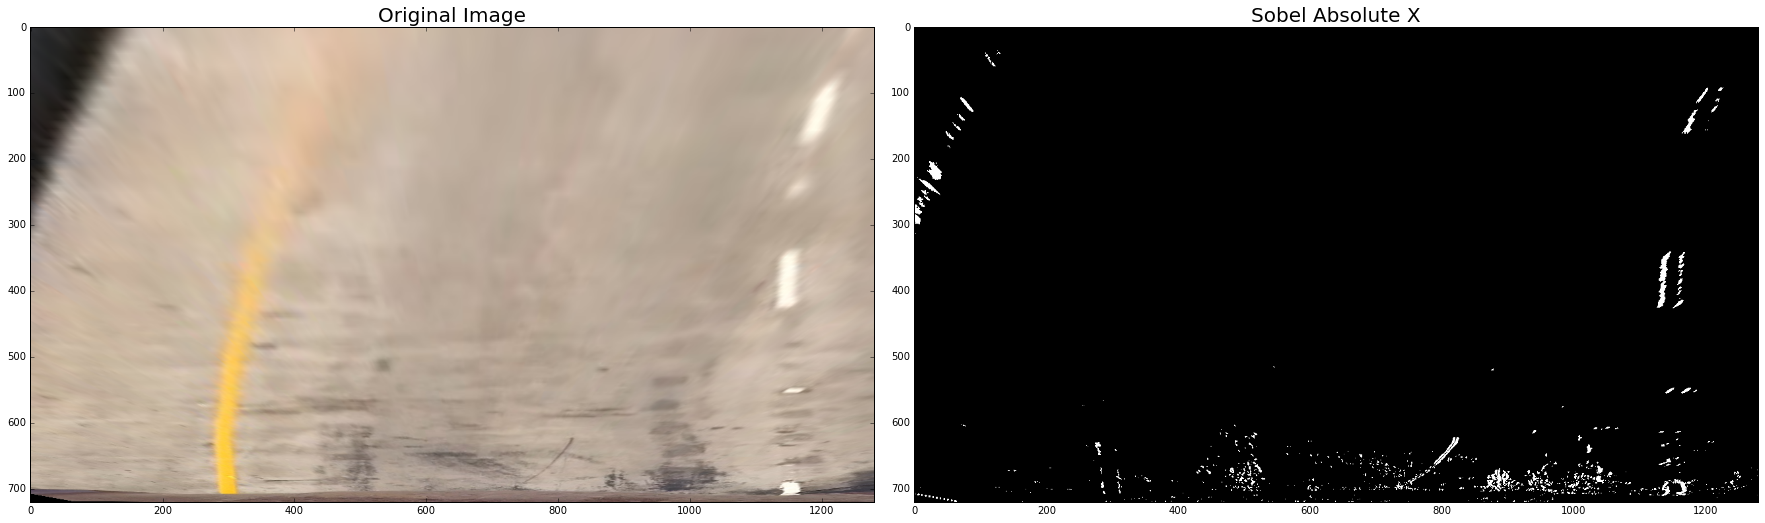

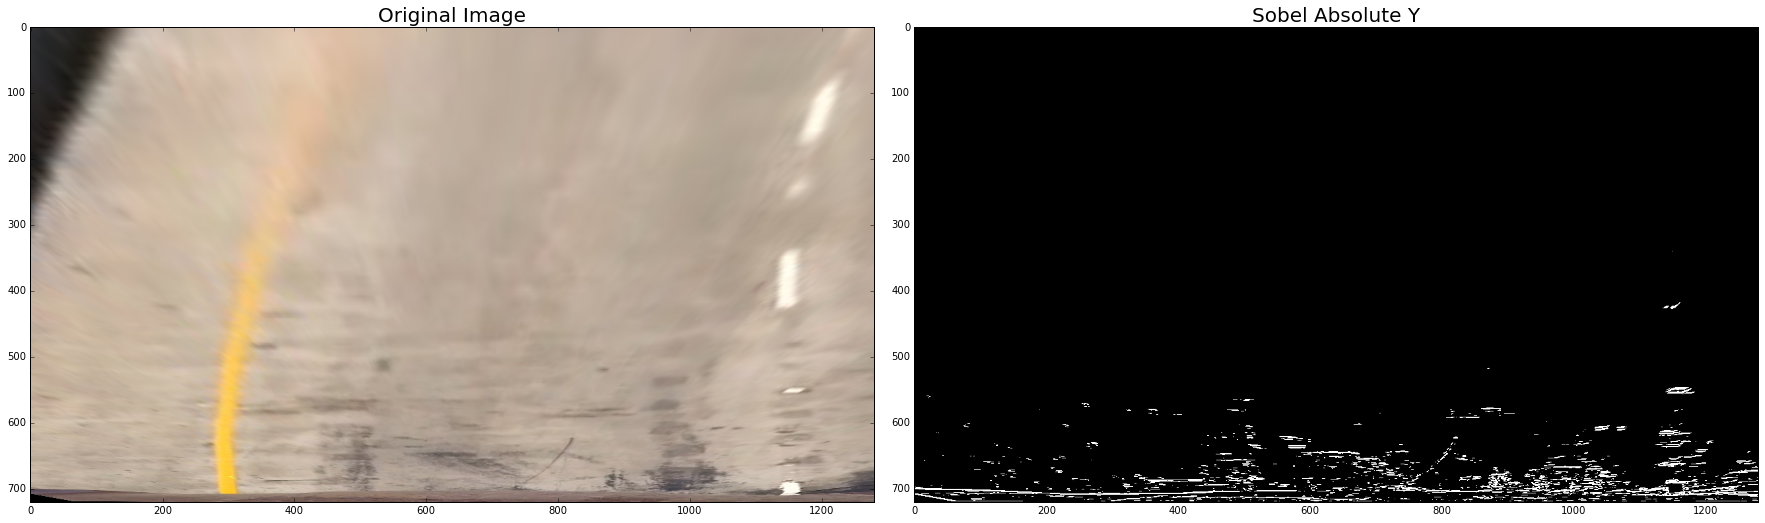

In [11]:
# Sobel transform the image
sobelx_img = abs_sobel_thresh(unwarped_image, 'x', 3, (25, 255))
sobely_img = abs_sobel_thresh(unwarped_image, 'y', 3, (25, 255))

# Plot the result
plt.gcf().clear()
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(unwarped_image)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(sobelx_img, cmap='gray')
ax2.set_title('Sobel Absolute X', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(unwarped_image)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(sobely_img, cmap='gray')
ax2.set_title('Sobel Absolute Y', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


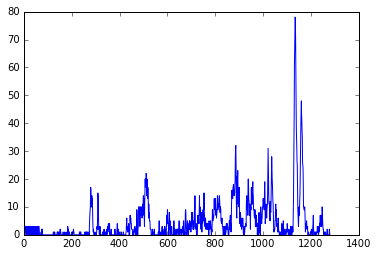

In [12]:
histogram = np.sum(sobelx_img[sobelx_img.shape[0]//2:,:], axis=0)
plt.gcf().clear()
plt.plot(histogram)

# histogram = np.sum(sobely_img[sobely_img.shape[0]//2:,:], axis=0)
# plt.plot(histogram)

# combined_sobel = np.zeros_like(dir_img)
# combined_sobel[((sobelx_img == 1) & (sobely_img == 1))] = 1
# #combined_img[((sobelx_img == 1) & (mag_img == 1))] = 1
# histogram = np.sum(combined_sobel[combined_sobel.shape[0]//2:,:], axis=0)
# plt.plot(histogram)

In [13]:
# Define a function that applies Sobel x and y, 
# then computes the magnitude of the gradient
# and applies a threshold
def mag_thresh(img, sobel_kernel=3, thresh=(0, 255)):
    
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= thresh[0]) & (gradmag <= thresh[1])] = 1
    
    return binary_output

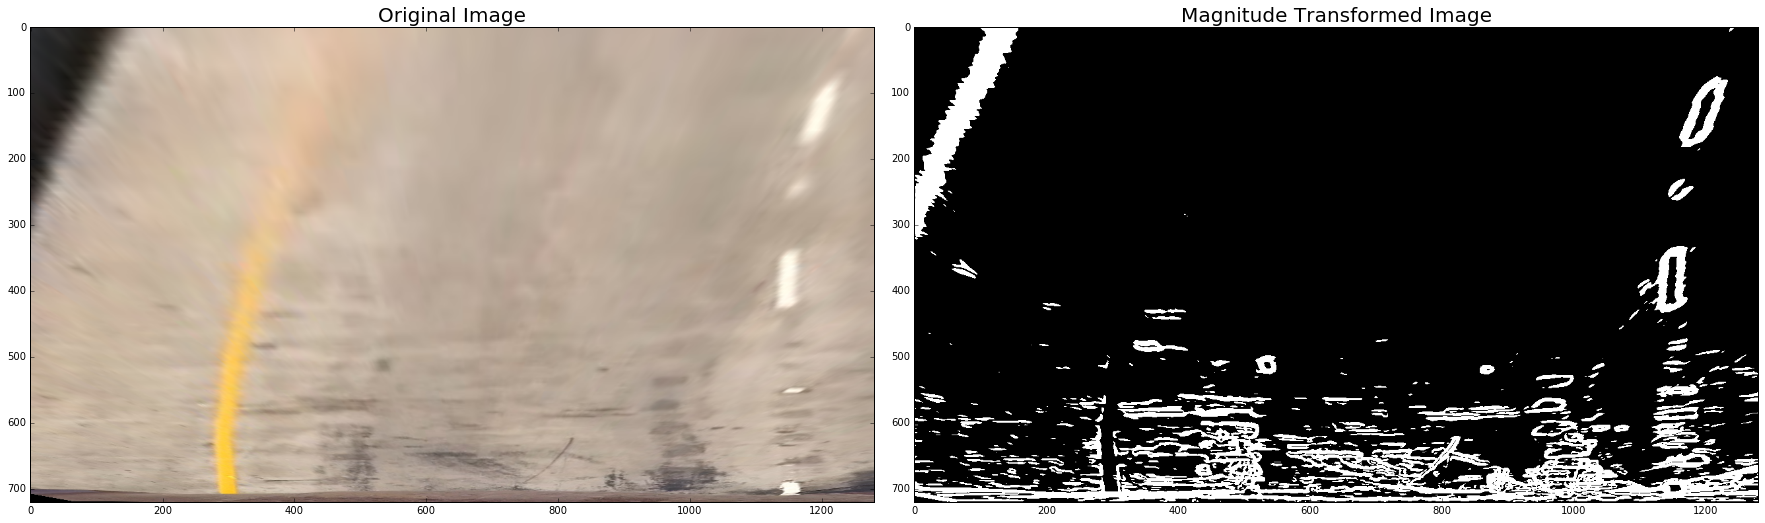

In [14]:
# magnitude transform the image
mag_img = mag_thresh(unwarped_image, sobel_kernel=11, thresh=(15, 255))

# Plot the result
plt.gcf().clear()
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(unwarped_image)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(mag_img, cmap='gray')
ax2.set_title('Magnitude Transformed Image', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


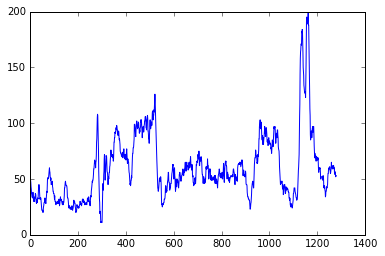

In [15]:
histogram = np.sum(mag_img[mag_img.shape[0]//2:,:], axis=0)
plt.gcf().clear()
plt.plot(histogram)

In [16]:
# Define a function that applies Sobel x and y, 
# then computes the direction of the gradient
# and applies a threshold.
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    
    return binary_output

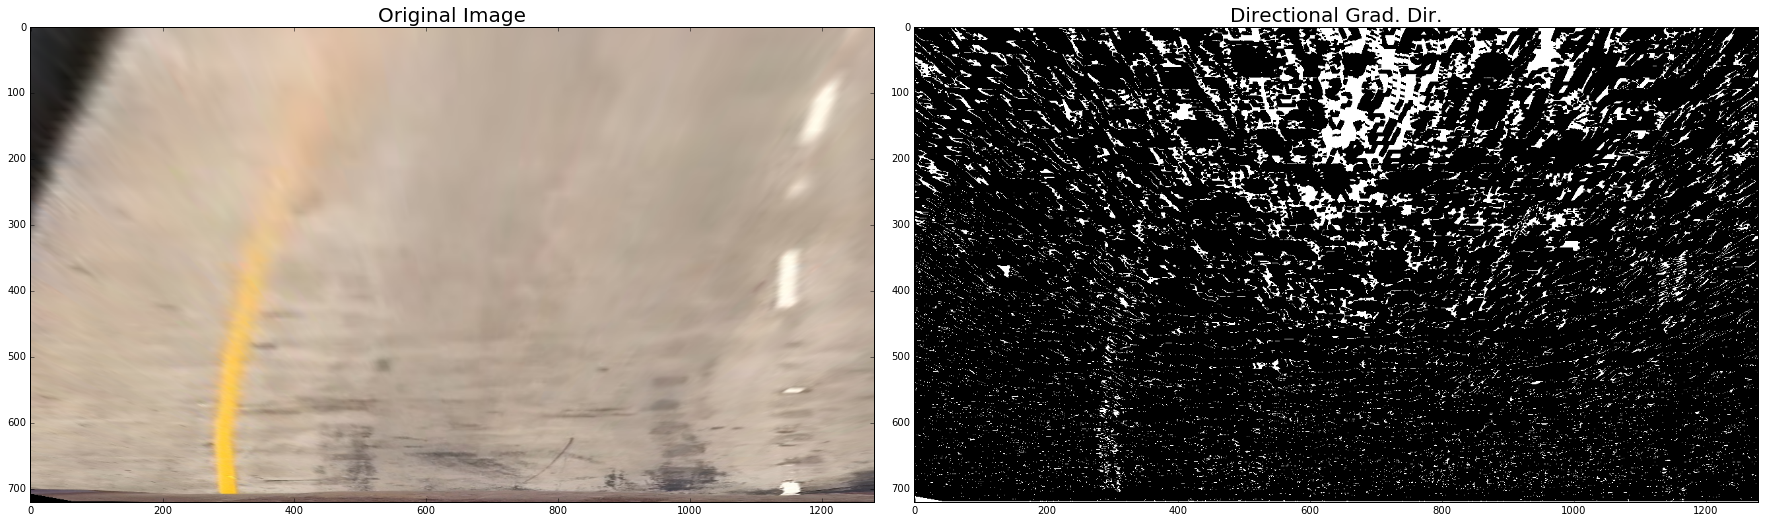

In [17]:
# directional gradient with sobel and magnitude 
dir_img = dir_threshold(unwarped_image, sobel_kernel=7, thresh=(0.0, 0.15))

# Plot the result
plt.gcf().clear()
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(unwarped_image)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(dir_img, cmap='gray')
ax2.set_title('Directional Grad. Dir.', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

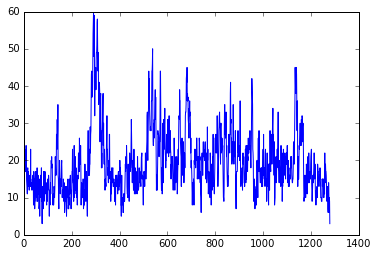

In [18]:
histogram = np.sum(dir_img[dir_img.shape[0]//2:,:], axis=0)
plt.gcf().clear()
plt.plot(histogram)

In [19]:
def hls_grad(img, hls_thresh=(150, 255)):

    # Convert to HLS color space and separate the S channel
    # Note: img is the undistorted image
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]

    # Threshold color channel
    #150,255
    s_thresh_min = hls_thresh[0]
    s_thresh_max = hls_thresh[1]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
    
    return s_binary

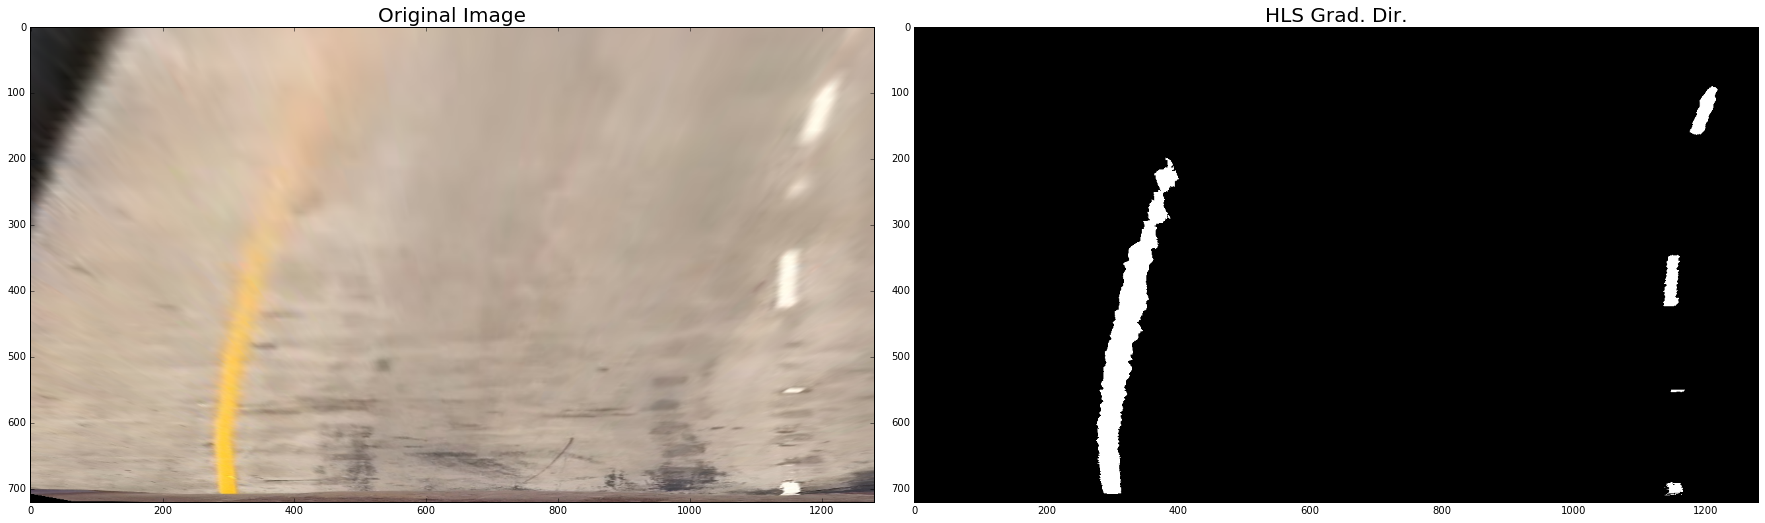

In [20]:
# hls and gradient combined
# as per 11.16
hlsg_image = hls_grad(unwarped_image, hls_thresh=(150, 255))

# Plot the result
plt.gcf().clear()
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(unwarped_image)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(hlsg_image, cmap='gray')
ax2.set_title('HLS Grad. Dir.', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

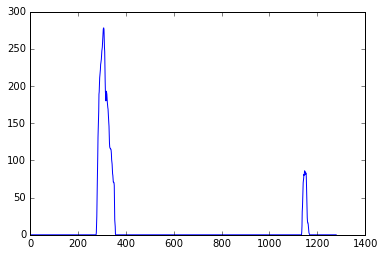

In [21]:
histogram = np.sum(hlsg_image[hlsg_image.shape[0]//2:,:], axis=0)
plt.gcf().clear()
plt.plot(histogram)


In [22]:
# utility function 
def combined_thresh(img, sobel_kernel=3, s_thresh=(15, 255), m_thresh=(20, 200), d_thresh=(0.0, 0.09), hls_thresh=(150, 255)):
    # Sobel transform the image
    sobelx_img = abs_sobel_thresh(img, orient='x',sobel_kernel=5, thresh=s_thresh)
    #sobely_img = abs_sobel_thresh(img, orient='y',sobel_kernel=5, thresh=s_thresh)
    
    # magnitude transform the image
    #mag_img = mag_thresh(img, sobel_kernel=11, thresh=m_thresh)
    
    # directional gradient with sobel and magnitude 
    #dir_img = dir_threshold(img, sobel_kernel=11, thresh=d_thresh)
    
    # HLS threshold - using S Channel
    hlsg_image = hls_grad(unwarped_image, hls_thresh)
    
    #combine them    
    combined_img = np.zeros_like(sobelx_img)
    #combined_img[((sobelx_img == 1) & (sobely_img == 1)) | ((mag_img == 1) & (dir_img == 1))] = 1
    #combined_img[((sobelx_img == 1) & (hlsg_image == 1) | (mag_img == 1))] = 1
    combined_img[((sobelx_img == 1) | (hlsg_image == 1))] = 1
    
    
    return combined_img
    

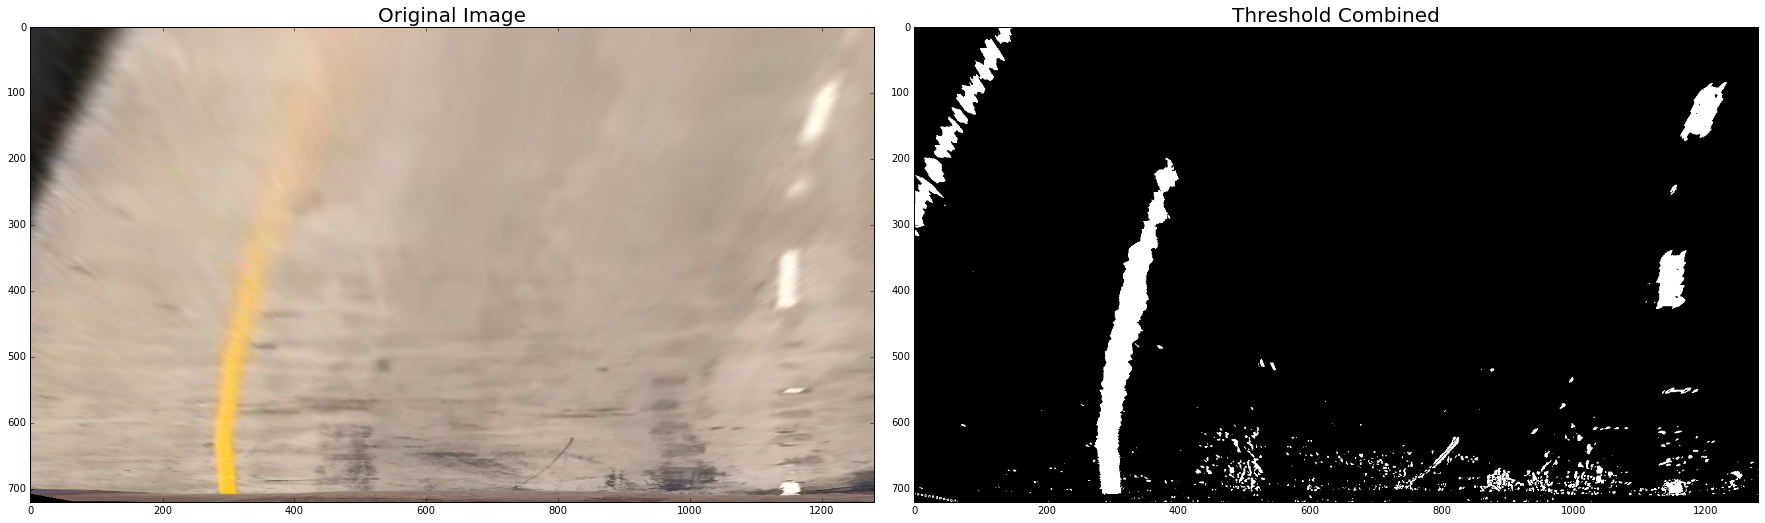

In [23]:
#combine them 
# combined_image = combined_thresh(unwarped_image, sobel_kernel=15, 
#     s_thresh=(15, 255), m_thresh=(15, 255), d_thresh=(0.0, 0.09), hls_thresh=(150, 255))

combined_image = combined_thresh(unwarped_image, sobel_kernel=15, 
    s_thresh=(20,100), hls_thresh=(150, 255))

# Plot the result
plt.gcf().clear()
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(unwarped_image)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(combined_image, cmap='gray')
ax2.set_title('Threshold Combined', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

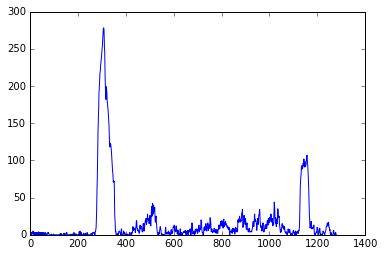

In [24]:
histogram = np.sum(combined_image[combined_image.shape[0]//2:,:], axis=0)
plt.gcf().clear()
plt.plot(histogram)

### As per lesson 16 - pretty much borrowed directly then adapted to use the above methods

In [25]:
# from lesson 16.34/35
#  method to Implement Sliding Windows and Fit a Polynomial
def sliding_window_fitpoly(binary_warped, test=False):
    # Take a histogram of the bottom half of the image 
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    
    if (test):
        # Create an output image to draw on and  visualize the result
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
        
    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]//nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Set the width of the windows +/- margin
    margin = 100
    
    # Set minimum number of pixels found to recenter window
    minpix = 50
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        if (test):
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high), (0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high), (0,255,0), 2) 

        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
        
    # Fit a second order polynomial to each
    left_fit, right_fit = (None, None)
    if len(leftx) != 0:
        left_fit = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit = np.polyfit(righty, rightx, 2)
    
    if (test):
        print('pts:', leftx, lefty, rightx, righty )
        print ('fits:', left_fit, right_fit)
        # Generate x and y values for plotting
        ploty = np.linspace(0, unwarped_image.shape[0]-1, combined_image.shape[0] )
        #print ('ploty:', ploty)
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = combined_image.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])

        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        
        histogram = np.sum(out_img[out_img.shape[0]//2:,:], axis=0)
        plt.plot(histogram)
        plt.show()
        plt.gcf().clear()

        
        f, ax1 = plt.subplots(1, 1, figsize=(20,10))
        ax1.set_title('Visualize lane lines')
        ax1.imshow(out_img)
        ax1.plot(left_fitx, ploty, color='yellow')
        ax1.plot(right_fitx, ploty, color='yellow')
        plt.show()
        plt.gcf().clear()
        
        histogram = np.sum(out_img[out_img.shape[0]//2:,:], axis=0)
        plt.plot(histogram)
        plt.show()
        
    return left_fit, right_fit, left_lane_inds, right_lane_inds

pts: [263 264 265 ..., 368 369 369] [640 640 640 ..., 290 290 291] [1130 1131 1132 ..., 1202 1203 1204] [640 640 640 ..., 159 159 159]
fits: [  5.38832913e-04  -7.02156520e-01   5.26114831e+02] [  3.46083072e-04  -3.73349371e-01   1.23749543e+03]


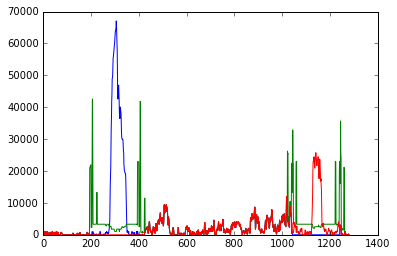

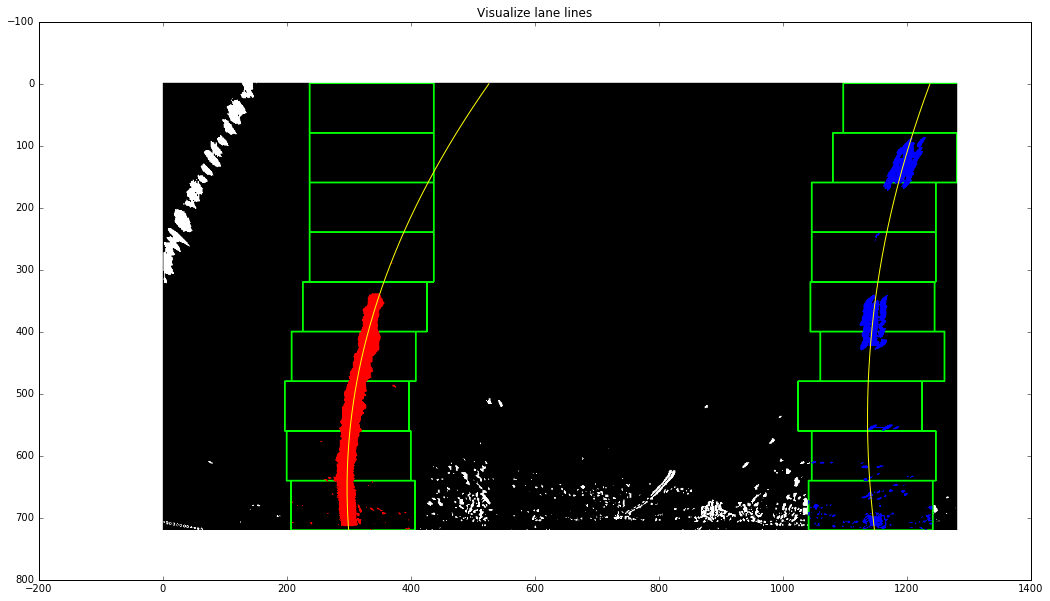

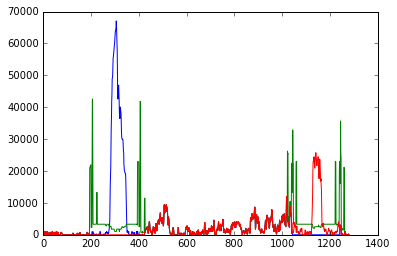

In [26]:
# test on an image
#image = cv2.imread('test_images/straight_lines2.jpg')
image = cv2.imread('test_images/test1.jpg')
#image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # fix colorspace
# Show perspective shifted image
image = undistort(image)
unwarped_image, M, Minv = perspective_shift(image)
combined_image = combined_thresh(unwarped_image, sobel_kernel=3, s_thresh=(20, 100), hls_thresh=(170, 255))

left_fit, right_fit, left_lane_inds, right_lane_inds = \
    sliding_window_fitpoly(combined_image, True)

#print ('left_fit, right_fit, left_lane_inds, right_lane_inds',left_fit, right_fit, left_lane_inds, right_lane_inds)

In [27]:
def sliding_window_fitnewpoly(binary_warped, left_fit, right_fit, test=False):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 80
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & 
                      (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & 
                       (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    left_fit_new, right_fit_new = (None, None)
    if len(leftx) != 0:
        # Fit a second order polynomial to each
        left_fit_new = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit_new = np.polyfit(righty, rightx, 2)

    if (test):
        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        # Create an image to draw on and an image to show the selection window
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        window_img = np.zeros_like(out_img)
        # Color in left and right line pixels
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                      ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                      ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
        
        plt.show()
        plt.gcf().clear()
        plt.imshow(result)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
        plt.show()
        plt.gcf().clear()
        
        
    return left_fit_new, right_fit_new, left_lane_inds, right_lane_inds


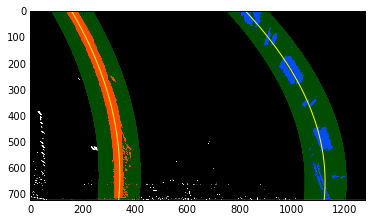

In [28]:
# test on an image
#image = cv2.imread('test_images/straight_lines2.jpg')
image = cv2.imread('test_images/test2.jpg')
#image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # fix colorspace
# Show perspective shifted image
image = undistort(image)
unwarped_image, M, Minv = perspective_shift(image)
combined_image = combined_thresh(unwarped_image, sobel_kernel=15, s_thresh=(15, 255), hls_thresh=(150, 255))

left_fit, right_fit, left_lane_inds, right_lane_inds = \
    sliding_window_fitpoly(combined_image, False)

left_fit2, right_fit2, left_lane_inds2, right_lane_inds2 = \
    sliding_window_fitnewpoly(combined_image,left_fit, right_fit, True)



### Calculate the radius of the curve


In [29]:
# from 16.37
def calc_curve(img, left_fit, right_fit, left_lane_inds, right_lane_inds):
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
    y_eval = np.max(ploty)
    
    #print("left_lane_inds: ", left_lane_inds)
                    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension, lane line is 10 ft = 3.048 meters
    xm_per_pix = 3.7/700 # meters per pixel in x dimension, lane width is 12 ft = 3.7 meters
    left_curverad, right_curverad, center_dist = (0, 0, 0)
  
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
        
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # numbers above for curve are in meters
    
    # Distance from center is image x midpoint - mean of left_fit and right_fit intercepts 
    #if right_fit is not None and left_fit is not None:
    car_position = img.shape[1]/2
    left_fit_x_int = left_fit[0]*img.shape[0]**2 + left_fit[1]*img.shape[0] + left_fit[2]
    right_fit_x_int = right_fit[0]*img.shape[0]**2 + right_fit[1]*img.shape[0] + right_fit[2]

    lane_center_position = (right_fit_x_int + left_fit_x_int) /2
    center = (car_position - lane_center_position) * xm_per_pix

    return left_curverad, right_curverad, center


In [30]:
print ('left_fit, right_fit, left_lane_inds, right_lane_inds:', left_fit, right_fit, left_lane_inds, right_lane_inds)
left_curverad, right_curverad, center = \
    calc_curve(combined_image, left_fit, right_fit, left_lane_inds, right_lane_inds)
print ('Radius of left and right edge:', left_curverad,'m, ', right_curverad,'m' )
print ('Center offset:', center,'m')


left_fit, right_fit, left_lane_inds, right_lane_inds: [ -4.68757692e-04   5.86584085e-01   1.58580389e+02] [ -7.15124450e-04   9.30721135e-01   8.24114907e+02] [46440 46441 46442 ...,  6842  6843  6844] [46480 46481 46482 ...,  6848  6849  6850]
Radius of left and right edge: 350.409337011 m,  229.700596071 m
Center offset: -0.479495033182 m


In [31]:
def draw_lane_lines(original_img, binary_img, left_fit, right_fit, Minv):
    new_img = np.copy(original_img)
    
    if left_fit is None or right_fit is None:
        return original_img
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    h,w = binary_img.shape
    ploty = np.linspace(0, h-1, num=h)# to cover same y-range as image
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(255,0,255), thickness=15)
    cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(0,255,255), thickness=15)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (w, h)) 
    # Combine the result with the original image
    result = cv2.addWeighted(new_img, 1, newwarp, 0.5, 0)
    return result


Radius of left and right edge: 349.160578852 m,  231.138287511 m
Center offset: -0.484259163297 m


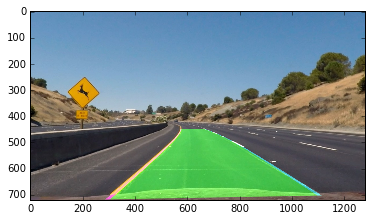

In [32]:
# test on an image
#image = cv2.imread('test_images/straight_lines2.jpg')
image = cv2.imread('test_images/test2.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # fix colorspace
image = undistort(image)

# perspective shifted image
unwarped_image, M, Minv = perspective_shift(image)
combined_image = combined_thresh(unwarped_image, sobel_kernel=15, s_thresh=(15, 255), hls_thresh=(150, 255))

left_fit, right_fit, left_lane_inds, right_lane_inds = \
    sliding_window_fitpoly(combined_image, False)

left_curverad, right_curverad, center = \
    calc_curve(combined_image, left_fit, right_fit, left_lane_inds, right_lane_inds)

print ('Radius of left and right edge:', left_curverad,'m, ', right_curverad,'m' )
print ('Center offset:', center,'m')

lined_image = draw_lane_lines(image, combined_image, left_fit, right_fit, Minv)
plt.imshow(lined_image)


In [33]:
def draw_telemetry(img, left_curverad, right_curverad, center):
    avg_curve = (left_curverad + right_curverad)/2
    
    new_img = np.copy(img)
    h = new_img.shape[0]
    
    font = cv2.FONT_HERSHEY_DUPLEX
    text = 'Curve radius: ' + '{:04.2f}'.format(avg_curve) + 'm'
    cv2.putText(new_img, text, (40,70), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    
    offset = ''
    if center > 0:
        offset = 'right'
    elif center < 0:
        offset = 'left'
    #abs_center_dist = abs(center_dist)
    text = '{:04.3f}'.format(center) + 'm ' + offset + ' of center'
    cv2.putText(new_img, text, (40,120), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    
    return new_img


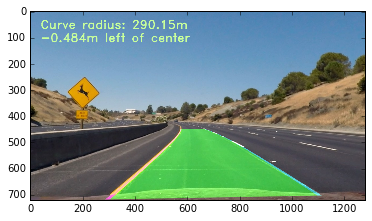

In [34]:
lined_image = draw_telemetry(lined_image, left_curverad, right_curverad, center)
plt.imshow(lined_image)

In [35]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
    def track_lines(self, fit):
        if fit is not None:
            if self.best_fit is not None:
                self.diffs = abs(fit - self.best_fit)
            # if the fit has drifted to far set undetected lane 
            # unless we have none then get started, this is pretty crude
            # and DL/ML model should be able to do beter
            #             if (self.diffs[0]*.1) > np.average(self.diffs, axis=0)and \
            #                len(self.current_fit) > 0: 
            if (self.diffs[0] > 0.001 or \
               self.diffs[1] > 1.0 or \
               self.diffs[2] > 100.0) and \
               len(self.current_fit) > 0:
                self.detected = False
            else:
                self.detected = True
                self.current_fit.append(fit)
                # only keep the 5 most current fits
                if len(self.current_fit) > 5:
                    self.current_fit = self.current_fit[len(self.current_fit)-5:]
                # simplistic best fit is just the average of the last 5
                self.best_fit = np.average(self.current_fit, axis=0)
        # if we don't have a fit, reset so we search all next time
        else:
            self.detected = False
            # only throw one away if we have at least one
            if len(self.current_fit) > 0:
                self.current_fit = self.current_fit[:len(self.current_fit)-1]
            # best_fit is their average of what is left
            if len(self.current_fit) > 0:
                self.best_fit = np.average(self.current_fit, axis=0)


### Process frames (images) from the video

In [36]:
# 
def process_frame(original_img):
    #new_img = np.copy(original_img)
    
    # undistort
    image = undistort(original_img)
    
    # perspective shifted image
    unwarped_image, M, Minv = perspective_shift(image)
    
    # combined threshold
#     combined_image = combined_thresh(unwarped_image, sobel_kernel=3, s_thresh=(15, 255), hls_thresh=(150, 255))
    
    # fall back to 20,200 and 170,255
    combined_image = combined_thresh(unwarped_image, sobel_kernel=15, s_thresh=(15, 255), hls_thresh=(150, 255))
    
    # find the lane lines - remember to use best fit from previous frame(s)
    if l_line.detected and r_line.detected:
         left_fit, right_fit, left_lane_inds, right_lane_inds = \
             sliding_window_fitnewpoly(combined_image, l_line.best_fit, r_line.best_fit, False)
    else:
        left_fit, right_fit, left_lane_inds, right_lane_inds = \
            sliding_window_fitpoly(combined_image, False)
    
    l_line.track_lines(left_fit)
    r_line.track_lines(right_fit)

        # calculate the curvature and center offset
    left_curverad, right_curverad, center = \
        calc_curve(combined_image, left_fit, right_fit, left_lane_inds, right_lane_inds)
    
    # draw the lane lines onto the undistorted image    
    if l_line.best_fit is not None and r_line.best_fit is not None:
        lined_image = draw_lane_lines(image, combined_image, left_fit, right_fit, Minv)
    else:
        # else we just keep the temp image?
        lined_image = new_img
    
    # add telemetry data 
    lined_image = draw_telemetry(lined_image, left_curverad, right_curverad, center)
        # if the top of our polygon gets too wide or too small suddenly, then 
    # houston, we have a problem and we need to reset our windowing
#     if left_fit is not None and right_fit is not None:
#         height = img.shape[0]
#         l_fit_x_intercept = left_fit[0]*height**2 + left_fit[1]*height + left_fit[2]
#         r_fit_x_intercept = right_fit[0]*height**2 + right_fit[1]*height + right_fit[2]
#         int_diff = abs(r_fit_x_intercept-l_fit_x_intercept)
#         # 300 pix is estimate - this needs solid math and code in the future
#         # 100 pix plus or minus gives me a buffer
#         if abs(350 - int_diff) > 100:
#             l_fit = None
#             r_fit = None
    
    return(lined_image)
    

In [37]:

l_line = Line()
r_line = Line()

video_out = 'project_video_output.mp4'
video_in = VideoFileClip('project_video.mp4')#.subclip(35,50)
processed_video = video_in.fl_image(process_frame)
%time processed_video.write_videofile(video_out, audio=False)


[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [03:09<00:00,  6.64it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 32min 23s, sys: 18.5 s, total: 32min 41s
Wall time: 3min 10s


In [38]:

%%HTML
<video width="960" height="540" controls>
  <source src="project_video_output.mp4" type="video/mp4">
</video>

In [39]:
# video_out = 'challenge_video_output.mp4'
# video_in = VideoFileClip('challenge_video.mp4')#.subclip(22,26)
# processed_video = video_in.fl_image(process_frame)
# %time processed_video.write_videofile(video_out, audio=False)

In [40]:
# video_out = 'harder_challenge_video_output.mp4'
# video_in = VideoFileClip('harder_challenge_video.mp4')#.subclip(22,26)
# processed_video = video_in.fl_image(process_frame)
# %time processed_video.write_videofile(video_out, audio=False)